In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import matplotlib.image as mpimg
import random
from sklearn import preprocessing
import tensorflow.keras as keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
SIZE = 256
SEED_TRAINING = 121
SEED_TESTING = 197
SEED_VALIDATION = 164
CHANNELS = 3
n_classes = 10
EPOCHS = 50
BATCH_SIZE = 32
input_shape = (SIZE, SIZE, CHANNELS)

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
        directory = 'Tomato/train',  # this is the input directory
        target_size = (256, 256),  # all images will be resized to 64x64
        batch_size = BATCH_SIZE,
        class_mode = 'categorical',
        color_mode="rgb")

Found 8243 images belonging to 10 classes.


In [17]:
validation_generator = validation_datagen.flow_from_directory(
        'Tomato/valid',
        target_size = (256, 256),
        batch_size = BATCH_SIZE,
        class_mode='categorical',
        color_mode="rgb")

Found 1844 images belonging to 10 classes.


In [18]:
test_generator = test_datagen.flow_from_directory(
        'Tomato/test',
        target_size = (256, 256),
        batch_size = BATCH_SIZE,
        class_mode = 'categorical',
        color_mode = "rgb"
)

Found 1859 images belonging to 10 classes.


In [8]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, CHANNELS))
base_model.trainable = False  # Freeze the base model

model = keras.models.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(n_classes, activation='softmax')
])



58889256/58889256 [==============================] - 21s 0us/step


In [9]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                        

In [13]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics  = ['accuracy']
    )

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50


257/257 [==============================] - 2141s 8s/step - loss: 1.2962 - accuracy: 0.5545 - val_loss: 25.2240 - val_accuracy: 0.1113 - lr: 0.0010
Epoch 2/50
257/257 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.7921

KeyboardInterrupt: 

In [ ]:
import streamlit as st
import requests
import asyncio

# चैटबॉट इंटरफेस के लिए CSS स्टाइलिंग
st.markdown("""
    <style>
    /* पृष्ठभूमि और फॉन्ट स्टाइलिंग */
    body {
        background-color: #f5f7fa;
        font-family: 'Arial', sans-serif;
    }
    /* चैट बटन स्टाइलिंग */
    .chat-button {
        position: fixed;
        bottom: 20px;
        right: 20px;
        background-color: #007bff;
        color: white;
        border-radius: 50%;
        width: 60px;
        height: 60px;
        display: flex;
        align-items: center;
        justify-content: center;
        font-size: 30px;
        cursor: pointer;
        box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2);
        transition: background-color 0.3s ease, transform 0.3s ease;
        z-index: 1000;
    }
    .chat-button:hover {
        background-color: #0056b3;
        transform: scale(1.1);
    }
    /* चैट विंडो स्टाइलिंग */
    .chat-window {
        position: fixed;
        bottom: 90px;
        right: 20px;
        width: 400px;
        max-height: 500px;
        background-color: #ffffff;
        border-radius: 15px;
        box-shadow: 0px 8px 24px rgba(0, 0, 0, 0.2);
        padding: 20px;
        overflow-y: auto;
        display: flex;
        flex-direction: column;
        z-index: 1000;
    }
    .chat-header {
        display: flex;
        justify-content: space-between;
        align-items: center;
        font-weight: bold;
        font-size: 18px;
        color: #333333;
        margin-bottom: 10px;
    }
    .chat-header button {
        background: none;
        border: none;
        cursor: pointer;
        font-size: 22px;
        color: #007bff;
    }
    .user-message {
        background-color: #e1f5fe;
        padding: 10px;
        border-radius: 10px;
        margin-bottom: 10px;
        max-width: 80%;
        align-self: flex-end;
        box-shadow: 0px 2px 6px rgba(0, 0, 0, 0.1);
    }
    .assistant-message {
        background-color: #c8e6c9;
        padding: 10px;
        border-radius: 10px;
        margin-bottom: 10px;
        max-width: 80%;
        align-self: flex-start;
        box-shadow: 0px 2px 6px rgba(0, 0, 0, 0.1);
    }
    .chat-container::-webkit-scrollbar {
        width: 8px;
    }
    .chat-container::-webkit-scrollbar-thumb {
        background-color: #cccccc;
        border-radius: 4px;
    }
    </style>
""", unsafe_allow_html=True)

# बॉट की प्रतिक्रिया दिखाना टाइपराइटर इफेक्ट के साथ
def display_bot_response(bot_text, container):
    asyncio.run(typewriter_effect(bot_text, container))

# टाइपराइटर इफेक्ट लागू करना
async def typewriter_effect(text, container):
    displayed_text = ""
    for char in text:
        displayed_text += char
        container.markdown(displayed_text)
        await asyncio.sleep(0.02)

# चैटबॉट प्रतिक्रिया के लिए API से डेटा प्राप्त करना
def get_bot_response(user_input: str):
    BASE_API_URL = "http://127.0.0.1:7860"
    FLOW_ID = "281516ad-f829-4eb1-b526-5b9a0472b928"
    api_url = f"{BASE_API_URL}/api/v1/run/{FLOW_ID}"
    payload = {"input_value": user_input, "output_type": "chat", "input_type": "chat"}
    try:
        response = requests.post(api_url, json=payload, timeout=10)  # टाइमआउट जोड़ा गया
        return response.json() if response.status_code == 200 else {"error": "अनुत्तर प्राप्त नहीं हुआ।"}
    except requests.exceptions.Timeout:
        return {"error": "अनुरोध समय समाप्त हो गया।"}
    except requests.exceptions.RequestException as e:
        return {"error": str(e)}

# API से प्राप्त प्रतिक्रिया को प्रोसेस करना
def process_response(bot_response_json):
    if "error" in bot_response_json:
        return bot_response_json["error"], None
    else:
        bot_text = bot_response_json.get("response", "कोई उत्तर नहीं मिला।")
        table_data = bot_response_json.get("table", None)
        return bot_text, table_data

# चैटबॉट इंटरफेस प्रदर्शित करना
def chatbot_interface():
    if st.session_state.chat_open:
        with st.container():
            st.markdown("<div class='chat-window'>", unsafe_allow_html=True)
            st.markdown("""
                <div class='chat-header'>
                    <span>पौधों के स्वास्थ्य परामर्श 🤖</span>
                    <button onclick="window.location.reload()">×</button>
                </div>
            """, unsafe_allow_html=True)

            chat_container = st.container()

            # सभी चैट संदेश दिखाएं
            for message in st.session_state.messages:
                if message["role"] == "user":
                    chat_container.markdown(f"<div class='user-message'>{message['content']}</div>", unsafe_allow_html=True)
                else:
                    chat_container.markdown(f"<div class='assistant-message'>{message['content']}</div>", unsafe_allow_html=True)

            # चैट इनपुट और बॉट प्रतिक्रिया प्रोसेसिंग
            prompt = st.text_input("आप मुझसे कुछ भी पूछ सकते हैं...", key="chat_input")
            if prompt:
                st.session_state.messages.append({"role": "user", "content": prompt})
                chat_container.markdown(f"<div class='user-message'>{prompt}</div>", unsafe_allow_html=True)

                bot_response_json = get_bot_response(prompt)
                bot_text, table_data = process_response(bot_response_json)

                if bot_text:
                    bot_container = st.empty()
                    display_bot_response(bot_text, bot_container)
                    st.session_state.messages.append({"role": "assistant", "content": bot_text})

            st.markdown("</div>", unsafe_allow_html=True)

# चैटबॉट सेक्शन को इंटरैक्टिव बनाना
def chatbot_section():
    # चैट स्टेट इनिशियलाइज करें
    if "chat_open" not in st.session_state:
        st.session_state.chat_open = False
    if "messages" not in st.session_state:
        st.session_state.messages = []

    # चैट बटन
    if st.button("💬"):
        st.session_state.chat_open = not st.session_state.chat_open

    # चैट इंटरफेस दिखाएं यदि चैट ओपन है
    chatbot_interface()

# चैटबॉट सेक्शन दिखाएं
if __name__ == "__main__":
    chatbot_section()

In [20]:
score = model.evaluate_generator(test_generator)
print('Test loss : ', score[0])
print('Test accuracy : ', score[1])

C:\Users\ha\AppData\Local\Temp\ipykernel_12708\3196870277.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator)


Test loss :  1.251627802848816
Test accuracy :  0.7154384255409241


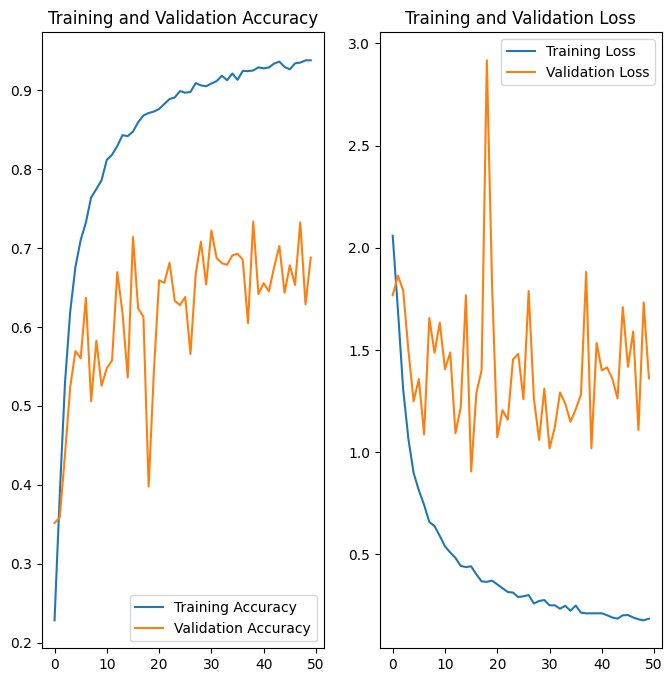

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [22]:
model.save('tomato_model.h5')

c:\Users\ha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
